# EDA

- Histograms sanity check
- Representatives from each group
- Aggregation of the data by Ilan's lab
  - See if improves reprentatives
- Heirechical Clustering
- Supervised classification

In [126]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats
from preprocessing import *
from config import *
import matplotlib.pyplot as plt
np.random.seed(42)
plt.style.use('ggplot')
plt.rcParams['lines.linewidth'] = 1

### Load data

In [127]:
track_length = 32

In [128]:
y = np.load(rf'data_files\labels_All{track_length}.npy')
x = np.load(rf'data_files\features_All{track_length}.npy')
print(x.shape, y.shape)

(4600, 32, 5) (4600,)


In [129]:
x.shape

(4600, 32, 5)

In [130]:
x_re = x.reshape(-1, x.shape[-1])
x_re.shape

(147200, 5)

## Histograms

### Latitude, Longtitude

<AxesSubplot:>

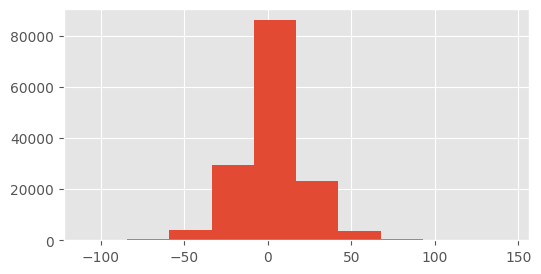

In [131]:
pd.Series(x_re[:,0]).hist(figsize = (6,3))

<AxesSubplot:>

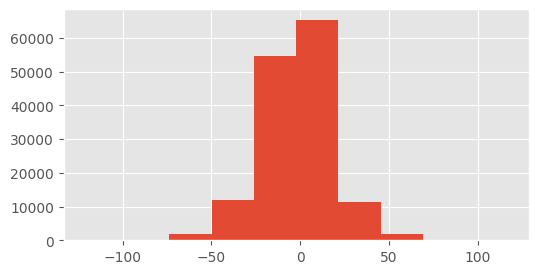

In [132]:
pd.Series(x_re[:,1]).hist(figsize = (6,3))

### Area

<AxesSubplot:>

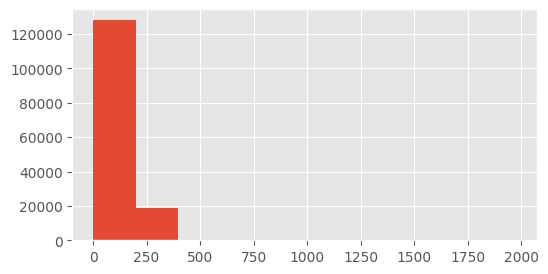

In [133]:
pd.Series(x_re[:,2]).hist(figsize = (6,3))

In [134]:
pd.Series(x_re[:,2]).describe()

count    147200.000000
mean        150.136902
std          52.307520
min           2.000000
25%         117.000000
50%         140.000000
75%         172.000000
max        1977.000000
dtype: float64

### Major Axis, Minor Axis

<AxesSubplot:>

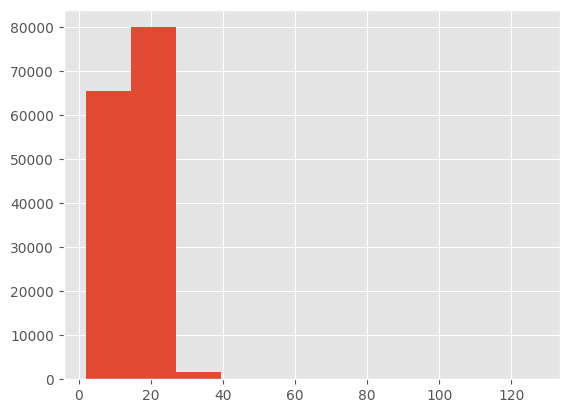

In [135]:
pd.Series(x_re[:,3]).hist()

<AxesSubplot:>

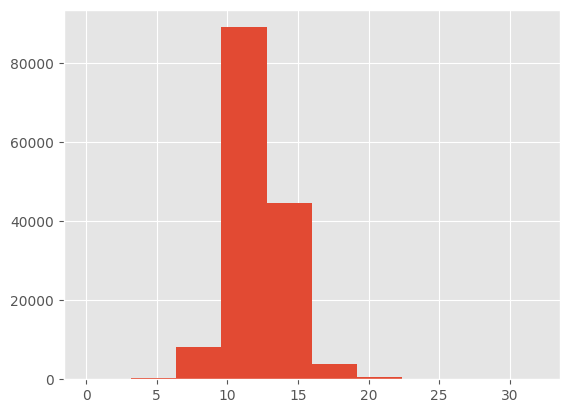

In [136]:
pd.Series(x_re[:,4]).hist()

## Normalize

In [137]:
scaler = StandardScaler()
x_norm = scaler.fit_transform(x.reshape(-1, x.shape[-1])).reshape(x.shape)
x_norm.shape

(4600, 32, 5)

In [138]:
no_outliers_idx = idx_no_outliers_after_norm(x_norm)
x_norm_no_out = x_norm[no_outliers_idx]
x_norm_no_out.shape

(4561, 32, 5)

In [139]:
x_norm_no_out_re = x_norm_no_out.reshape(-1, x_norm_no_out.shape[-1])
x_norm_no_out_re.shape

(145952, 5)

### Histograms

<AxesSubplot:>

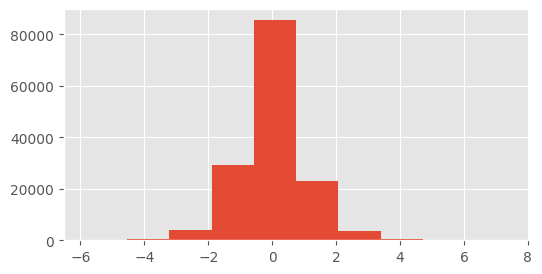

In [140]:
pd.Series(x_norm_no_out_re[:,0]).hist(figsize = (6,3))

<AxesSubplot:>

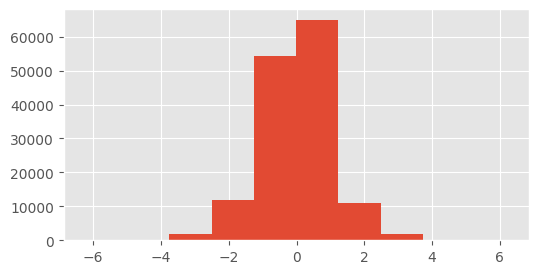

In [141]:
pd.Series(x_norm_no_out_re[:,1]).hist(figsize = (6,3))

<AxesSubplot:>

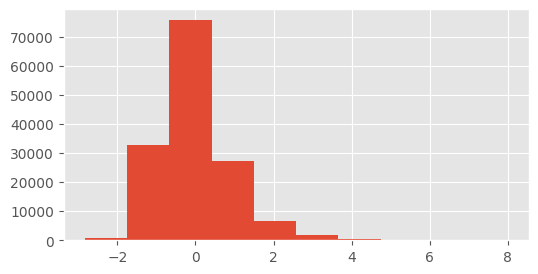

In [142]:
pd.Series(x_norm_no_out_re[:,2]).hist(figsize = (6,3))

<AxesSubplot:>

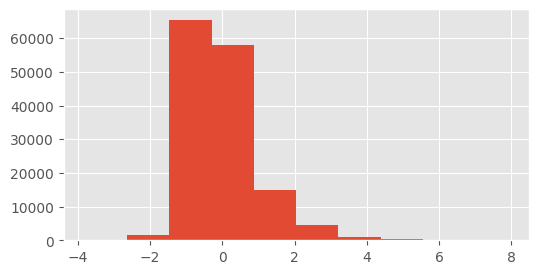

In [143]:
pd.Series(x_norm_no_out_re[:,3]).hist(figsize = (6,3))

<AxesSubplot:>

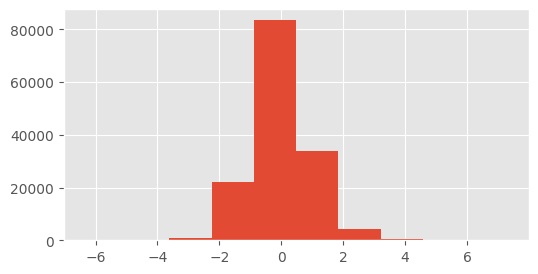

In [144]:
pd.Series(x_norm_no_out_re[:,4]).hist(figsize = (6,3))

## Label distribution

- Well distribution

In [145]:
y.shape

(4600,)

In [146]:
y_no_out = y[no_outliers_idx]
y_no_out.shape

(4561,)

<AxesSubplot:>

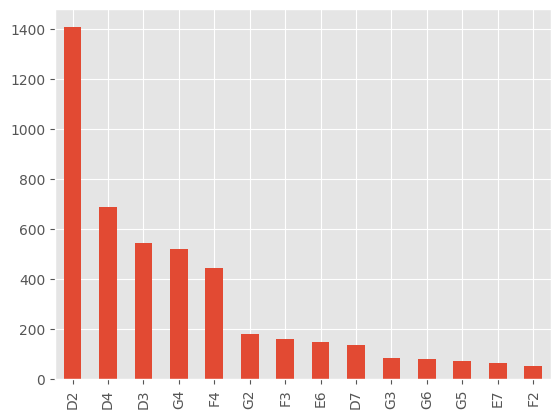

In [147]:
pd.Series(y_no_out).value_counts().plot.bar()

In [148]:
pd.Series(y).value_counts()

D2    1427
D4     687
D3     550
G4     519
F4     446
G2     178
F3     159
E6     148
D7     137
G3      85
G6      79
G5      74
E7      62
F2      49
dtype: int64

In [149]:
y2treat = pd.Series(y).map(wells_to_genetype_dict)

<AxesSubplot:>

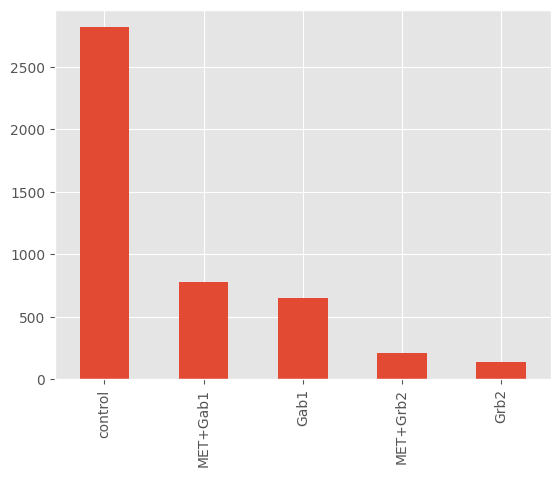

In [150]:
y2treat.value_counts().plot.bar()

## Data Transformation

In [151]:
X_train = x_norm_no_out.copy()
traj = X_train[:,:,:2]
traj.shape

(4561, 32, 2)

In [152]:
from preprocessing import *

def spheroid(long_sq,short_sq):
    return np.sqrt((long_sq-short_sq)/long_sq) if long_sq!=short_sq else 0
def elip(majorminor):
    maj_sq = majorminor[0]**2
    min_sq = majorminor[1]**2
    return spheroid(maj_sq,min_sq) if maj_sq>min_sq else spheroid(min_sq,maj_sq)

def getAngleRad(diffs):
    return np.arctan2(diffs[1], diffs[0])
def getAngleRadZero(xy):
    return np.arctan2(xy[1]-0, xy[0]-0)

def add_transformations(X_train):
    #ellipticity
    ellipticity = np.apply_along_axis(elip, 2, X_train[:,:,3:5])
    X_train = np.dstack((X_train,ellipticity))
    #step size
    d = np.diff(X_train[:,:,:2],axis=1,prepend=0)
    step_size = np.sqrt(np.power(d,2).sum(axis=2))
    X_train = np.dstack((X_train,step_size))
    #displacement
    displacement = np.sum(X_train[:,:,:2]**2,axis=2)
    X_train = np.dstack((X_train,displacement))
    #acceleration
    acceleration = np.diff(step_size,axis=1,prepend=0)/30.0
    X_train = np.dstack((X_train,acceleration))
    #angle of step
    d = np.diff(X_train[:,:,:2],axis=1,prepend=0)
    angles_of_step = np.apply_along_axis(getAngleRad, 2, d)
    X_train = np.dstack((X_train,angles_of_step))
    #angle from center
    angles_from_center = np.apply_along_axis(getAngleRad, 2, X_train[:,:,:2])
    X_train = np.dstack((X_train,angles_from_center))

    return X_train

In [153]:
X_transform = add_transformations(X_train)
X_transform.shape

(4561, 32, 11)

## Baseline Analysis - Manual Features

In [154]:
displacement = np.sum(x_norm[:,:,:2]**2,axis=2)
displacement.shape

(4600, 32)

In [155]:
displacement.mean(axis=1).shape

(4600,)

In [156]:
y.shape

(4600,)

In [157]:
d_mean = displacement.mean(axis=1)
d_mean.shape

(4600,)

In [158]:
y2treat = pd.Series(y).map(wells_to_genetype_dict)

In [160]:
# pd.DataFrame(columnns= [y,displacement.mean(axis=1))
df = pd.DataFrame(d_mean, columns = ['D'])
df['treat'] = y2treat

<AxesSubplot:xlabel='treat'>

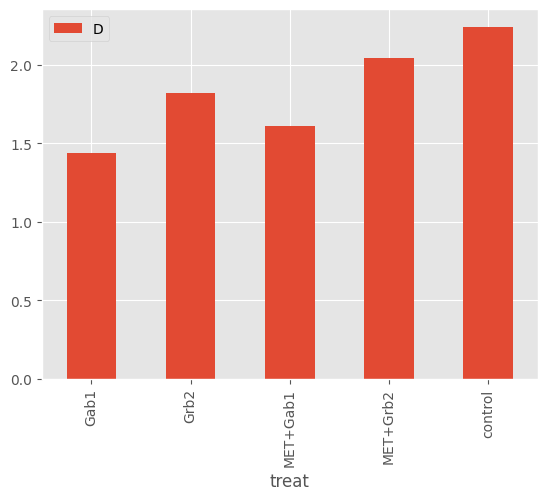

In [161]:
df.groupby('treat').mean().plot.bar()

In [162]:
model.predict(displacement).shape

c:\Projects\TAU\DL-Workshop\Git Folder\Env\dl_work_mod\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 4600 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


(4600,)

In [164]:
# kShape clustering
from tslearn.clustering import KShape, TimeSeriesKMeans , silhouette_score 

X_train = displacement.copy()
sz = X_train.shape[1]
ks = TimeSeriesKMeans(n_clusters=3,metric="dtw", verbose=False, random_state=42)
y_pred = ks.fit_predict(X_train)


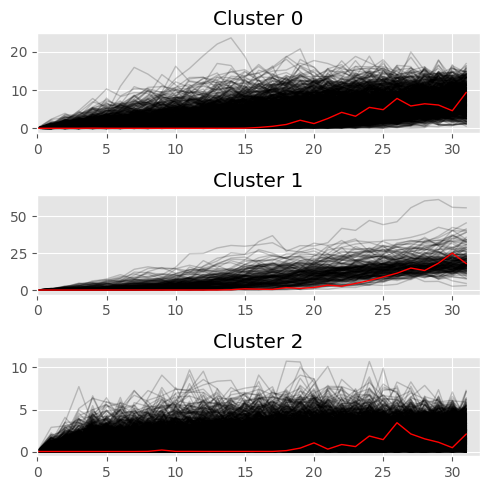

In [ ]:
plt.figure(figsize= (5,5))
for yi in range(3):
    plt.subplot(3, 1, 1 + yi)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(ks.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.title("Cluster %d" % (yi))

plt.tight_layout()
plt.show()

In [165]:
df['cluster'] = y_pred

In [ ]:
# treat_well = dtc.predict(X_train[np.where(np.isin(y,gab1_met))])
# pd.Series(treat_well).value_counts(normalize=True).sort_index().plot.bar(ylim=(0,0.7))

In [166]:
df_treat_clustr = df[['treat','cluster']]

In [167]:
df_plot = df[['treat','cluster']].groupby(['treat','cluster']).size().reset_index()
df_plot

,treat,cluster,0
0,Gab1,0,102
1,Gab1,1,7
2,Gab1,2,545
3,Grb2,0,26
4,Grb2,1,4
5,Grb2,2,107
6,MET+Gab1,0,161
7,MET+Gab1,1,15
8,MET+Gab1,2,606
9,MET+Grb2,0,55


In [169]:
df_sum = df_plot.groupby(['treat']).sum()

In [ ]:
df_m = pd.merge(df_plot,df_sum, on ='treat')
df_m['norm'] = df_m['0_x']/df_m['0_y']

<AxesSubplot:ylabel='treat,cluster_x'>

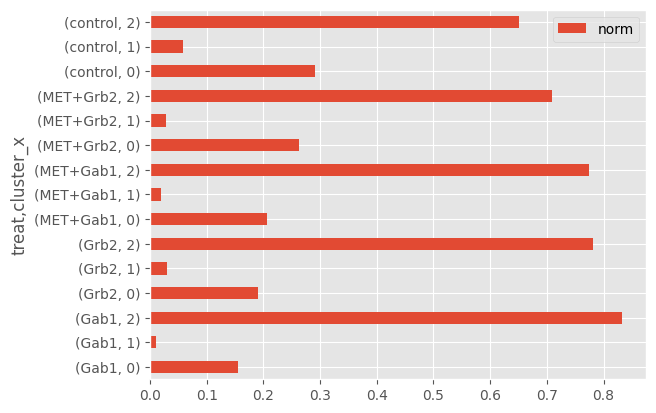

In [170]:
df_m[['treat','cluster_x','norm']].groupby(['treat','cluster_x']).max().plot.barh()

In [ ]:
import matplotlib.pyplot as plt

def plot_representatives(rep_groups,figsize = (10,20)):
    l = len(rep_groups[0])
    L = len(rep_groups)
    fig, axs = plt.subplots(l,L, figsize=figsize,sharey=True,sharex=True)
    fig.tight_layout()
    for j,reps in enumerate(rep_groups):
        for i,rep in enumerate(reps):
            axs[i,j].plot(rep[:,0],rep[:,1])
    fig.show()

## Representatives

In [179]:
from plotting_funcs import *

In [177]:
X_train = x_norm.copy()

In [183]:
le = LabelEncoder()
le.fit(list(wells_to_genetype_dict.values()))
treat2lbl = le.transform(y2treat.values)
treat2lbl


array([2, 2, 4, ..., 4, 4, 4])

## Visualizing examples of trajectories of different treatments

C:\Users\asafavra\AppData\Local\Temp\ipykernel_3652\3580321816.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


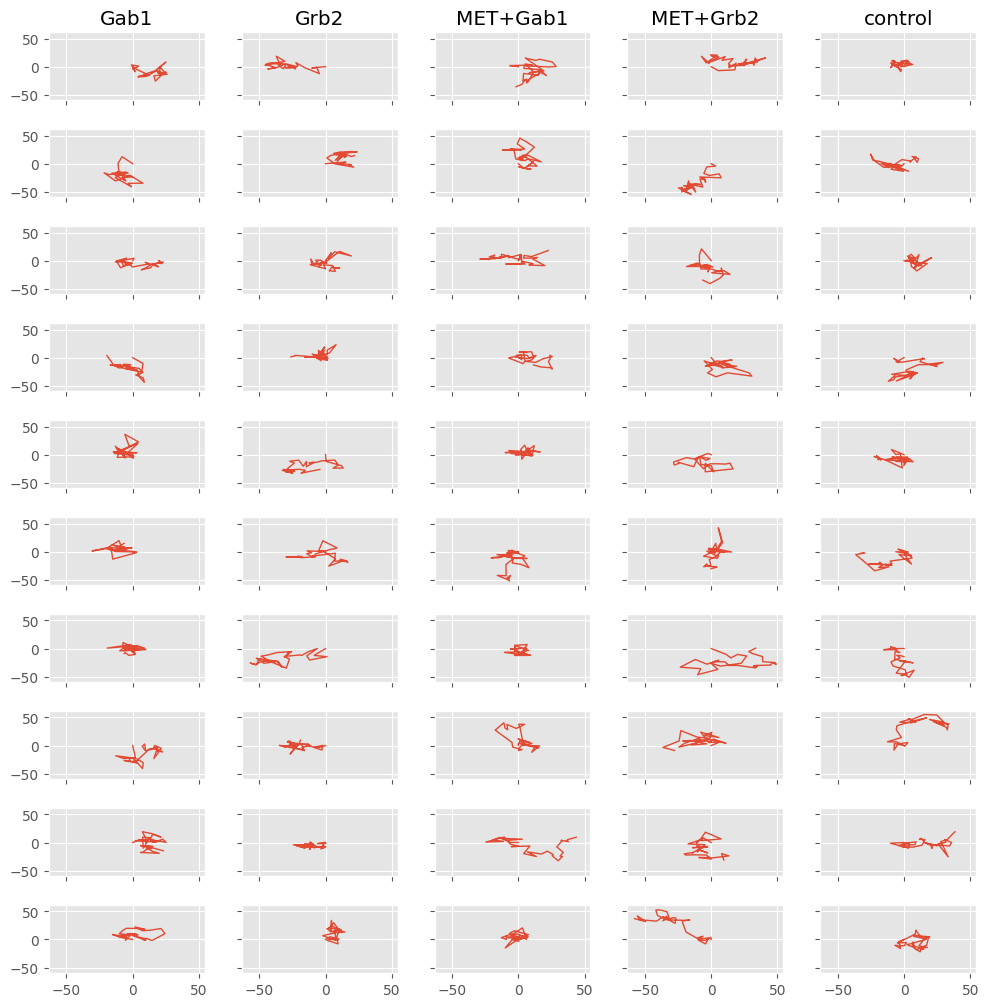

In [188]:
rep_list = []
size = 10
for i in range(5):
  cluster_vec = x[np.where(np.isin(treat2lbl,[i]))]
  cluster_list = cluster_vec[np.random.choice(cluster_vec.shape[0], size, replace=False)]
  rep_list.append(cluster_list)

plot_representatives_treatment_le(rep_list,le)

### Visualizing the morpho-kinetic features of cells over time
- Notice the volatility of The morphological features (shape of elipse)

C:\Users\asafavra\AppData\Local\Temp\ipykernel_3652\2679277544.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


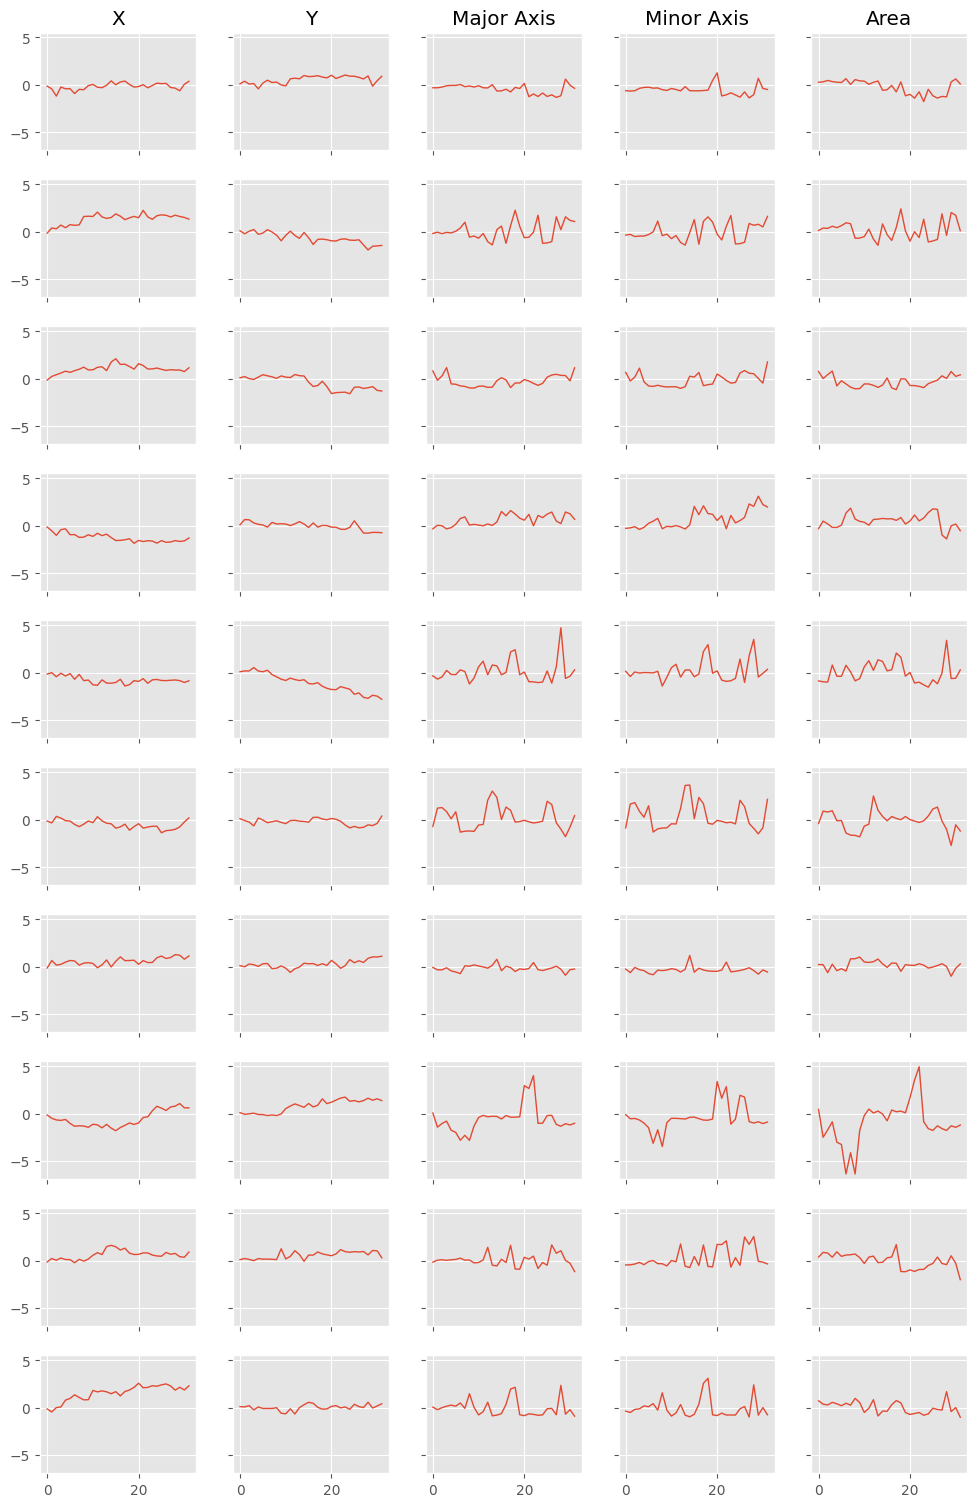

In [175]:
size = 10
rand_idx = np.random.choice(X_train.shape[0], size, replace=False)
orig_vec = X_train[rand_idx,:,:]
plot_features_by_time(orig_vec)